## Introduction

I obtained data on Airbnbs in Edinburgh for both 2019/20 (compiled on 25th June 2019) and 2020/21 (compiled on 23rd June 2020). All of the data were collected by the [Inside Airbnb](http://insideairbnb.com/get-the-data.html) project, although only the most recent year is available on their website. The 2019-20 data were sourced on [Kaggle](https://www.kaggle.com/thoroc/edinburgh-inside-airbnb). Here, I take a first look at the **listings** from the **2019/20** data.

The data has 106 fields describing 13,245 Airbnb listings.

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import scipy as sp

plt.rcParams["figure.figsize"] = (20,10)

listings = pd.read_csv('../data19/listings.csv')
listings.shape

(13245, 106)

In [97]:
[print(col) for col in listings.columns]

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_ni

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Exploring Pricing

First I transform the price columns into numeric values. 

In [98]:
from pandas.api.types import is_numeric_dtype

def format_price(dataframe, column):
    if not is_numeric_dtype(dataframe[column]):
        dataframe[column] = dataframe[column].str.replace('$', '')
        dataframe[column] = dataframe[column].str.replace(',', '')
        dataframe[column] = pd.to_numeric(dataframe[column])

format_price(listings, "price")
format_price(listings, "extra_people")
format_price(listings, "cleaning_fee")
format_price(listings, "security_deposit")

Airbnbs can opt to charge extra for additional people staying in larger properties. The `price` column only refers to `guests_included`, and additional guests are charged at `extra_people`. Therefore, I can create another column which is price per included guest (`price_pig` = `price`/`guests_included`). I can also create a column that is price at full capacity (`price_fullcap` = `price` + `extra_people` * (`accomodates` - `guests_included`)). On 6 occassions this results in a negative number for `price_fullcap`, because the owner of the Airbnb has listed the price as including more individuals than the property can accomodate. In such cases, `price_fullcap` is just set to `price`.

In [99]:
listings = listings.assign(price_pig = lambda dataframe : dataframe['price']/dataframe['guests_included'])

listings = listings.assign(price_fullcap = lambda dataframe : dataframe['price'] + dataframe['extra_people'] * (dataframe['accommodates'] - dataframe['guests_included']))

listings.query('price_pig > price_fullcap')[['price_pig', 'price_fullcap', 'accommodates', 'price', 'extra_people', 'guests_included']]

listings['price_fullcap'] = np.where((listings.price_pig > listings.price_fullcap),listings.price,listings.price_fullcap)

There are also additional fees associated with staying in some of the Airbnbs: cleaning fees and security deposits. I cannot add these to the price, but I can create an indicator variable to show whether or not an Airbnb has these charges.

In [100]:
listings['security_deposit_required'] = listings['security_deposit'].apply(lambda x: 1 if (x > 0) else 0)
listings['cleaning_fee_required'] = listings['cleaning_fee'].apply(lambda x: 1 if (x > 0) else 0)

In [101]:
print("Proportion of Airbnbs that request security deposits: ", listings.security_deposit_required.sum()/len(listings.index))
print("Proportion of Airbnbs that request cleaning fees: ", listings.cleaning_fee_required.sum()/len(listings.index))

Proportion of Airbnbs that request security deposits:  0.3755379388448471
Proportion of Airbnbs that request cleaning fees:  0.6079275198187996


## Missing Data & Duplicates

In [102]:
listings.drop_duplicates().shape

(13245, 110)

In [103]:
listings.isna().any().any()

True

There are no duplicated records in this dataset, but there are missing data. 

In [104]:
listings.loc[:, listings.isnull().any()].columns

Index(['name', 'summary', 'space', 'description', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_s

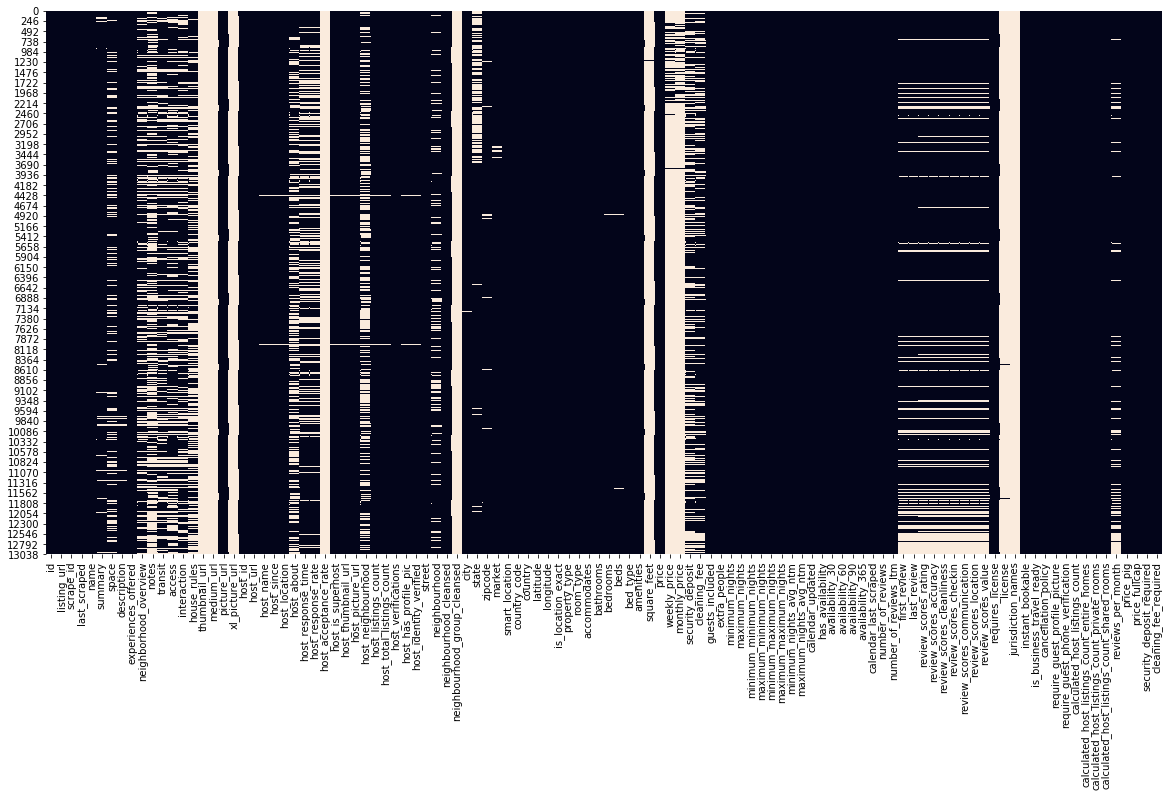

In [105]:
sn.heatmap(listings.isnull(), cbar=False)

In [106]:
print("% missing values for columns with missing values")
for (columnName, contents) in listings.iteritems():
    missing = 100 - ((len(listings.index) - contents.isnull().sum())/len(listings.index) * 100)
    if (missing != 0):
        print(columnName, ": ", "{0:.2f}".format(missing))

% missing values for columns with missing values
name :  0.01
summary :  2.86
space :  21.93
description :  0.94
neighborhood_overview :  28.49
notes :  53.45
transit :  26.87
access :  31.61
interaction :  28.28
house_rules :  38.44
thumbnail_url :  100.00
medium_url :  100.00
xl_picture_url :  100.00
host_name :  0.14
host_since :  0.14
host_location :  0.42
host_about :  42.35
host_response_time :  25.59
host_response_rate :  25.59
host_acceptance_rate :  100.00
host_is_superhost :  0.14
host_thumbnail_url :  0.14
host_picture_url :  0.14
host_neighbourhood :  42.94
host_listings_count :  0.14
host_total_listings_count :  0.14
host_has_profile_pic :  0.14
host_identity_verified :  0.14
neighbourhood :  17.32
neighbourhood_group_cleansed :  100.00
city :  0.12
state :  19.25
zipcode :  1.61
market :  1.55
bathrooms :  0.09
bedrooms :  0.03
beds :  0.11
square_feet :  99.81
weekly_price :  91.12
monthly_price :  94.05
security_deposit :  35.81
cleaning_fee :  28.24
first_review :  15.

Columns with missing data fall into the following categories:
- URLs (e.g. `host_thumbnail_url`). I am not interested in these anyway. They're likely to be missing when individuals have not uploaded pictures.
- User-entered text (e.g. `description`). These I may be interested in. They could be missing if the user has not filled them out.
- Host attributes (e.g. `host_neighbourhood`). It is less clear to me why these would be missing.
- Review attributes (e.g. `review_scores_rating`). It could be that these are missing when there are no reviews for that property. 
- Property attributes (e.g. `bathrooms`). It is unclear why these would be missing, but thankfully they never have more than 1% missing values. 

I remove any columns that I will not use in the future or that are made entirely or almost entirely of missing values. 

In [107]:
listings = listings.drop(['thumbnail_url', 'medium_url', 'xl_picture_url', 'host_thumbnail_url',
              'host_picture_url', 'city', 'state', 'license', 'jurisdiction_names',
              'experiences_offered', 'access', 'interaction', 'has_availability', 'market', 
              'neighbourhood_group_cleansed', 'host_acceptance_rate', 'zipcode', 'square_feet',
              'weekly_price', 'monthly_price', 'name', 'host_total_listings_count', 'country_code',
              'cleaning_fee', 'security_deposit', 'number_of_reviews_ltm', 'first_review',
              'last_review', 'host_name', 'host_neighbourhood'],
              axis = 1)

The missingness I am most concerned about is for `neighbourhood`. I am very interested in this column, but it has substantial missingness (17.32%), and as a categorical variable with many levels would not be easy to impute. I am forced to take a complete cases approach to `neighbourhood`. 

In [108]:
have_neighbourhood = np.invert(listings.neighbourhood.isnull().to_numpy())
listings = listings[have_neighbourhood]

I choose to median impute values for columns that I deem essential (mostly property columns). These columns have less than 1% missing values, and thus I feel little need to perform a computationally intensive imputation process. My median imputation is designed to avoid potential bias introduced by a complete cases approach. Columns treated with median imputation were `host_listings_count`, `bathrooms`, `bedrooms` and `beds`. As it turns out, the medians for these columns are 1, 1, 2, and 1, respectively.

In [109]:
for column in ['host_listings_count', 'bathrooms', 'beds', 'bedrooms']:
    listings.loc[(listings[column].isnull()), column] = listings[column].median()

For binary variables that I am interested in, like whether a host is a superhost, that have very few missing values, I just replace the missing value with the most common value.

In [110]:
# make all trues and falses into 1s and 0s 
listings = listings.replace('t', 1)
listings = listings.replace('f', 0)

In [111]:
for column in ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'host_response_time', 'host_response_rate']:
    listings.loc[(listings[column].isnull()), column] = listings[column].value_counts().index[0]

For host attributes and ratings, note that there are clearly clusters of missingness. Records missing a single review value are likely to be missing them all, and records missing a single host response attribute are likely to be missing more than just this one host response attribute. Unfortunately, this also makes them difficult to impute using an iterative algorithm, which would assume that some rating values or some host attributes would be available upon which to base a decision on the missing values. Given this, I also choose to do median imputation for these variables.

This does make some sense. Airbnbs without review columns are likely to have just not received any reviews. This could be because they went live relatively recently (although it could also be because they have not been booked out much - which could be a problem). So it is natural to expect they will perform averagely. The same can be said for hosts with missing values, who may have not yet replied to any inquiries. However, to account for the fact this may be due to poor presentation of the Airbnb, I also add the `ever_reviewed` indicator variable.

In [112]:
listings['ever_reviewed'] = listings['review_scores_rating'].apply(lambda x: 0 if (np.isnan(x)) else 1)

In [113]:
for column in ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_communication',
              'review_scores_checkin', 'review_scores_location', 'reviews_per_month', 'review_scores_value']:
    listings.loc[(listings[column].isnull()), column] = listings[column].median()

The remaining columns with missing values are those with text blocks: like reviews, descriptions of the let, and house rules. I create indicator variables for each of these. 

In [114]:
for column in ['description', 'space', 'neighborhood_overview', 'notes', 'house_rules', 'transit']:
    listings['has_' + column] = listings[column].apply(lambda x: 1 if (pd.isnull(x)) else 0)

Index(['summary', 'space', 'description', 'neighborhood_overview', 'notes',
       'transit', 'house_rules', 'host_since', 'host_location', 'host_about'],
      dtype='object')

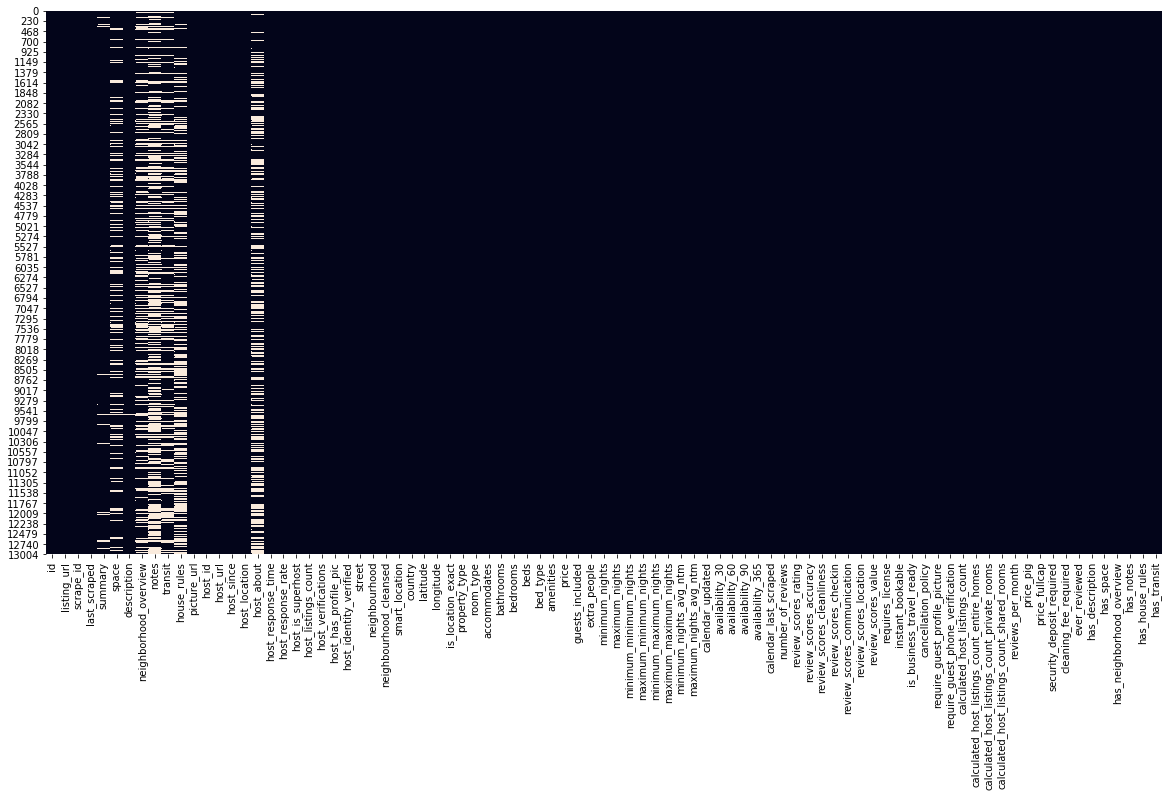

In [115]:
sn.heatmap(listings.isnull(), cbar=False)
listings.loc[:, listings.isnull().any()].columns

### Distributions and Outlier Detection 

The histogram of price per included guest shows an extreme right skew. Price here refers to the **mean** price per included guests per night over a 365 day period. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D7D2175D88>]],
      dtype=object)

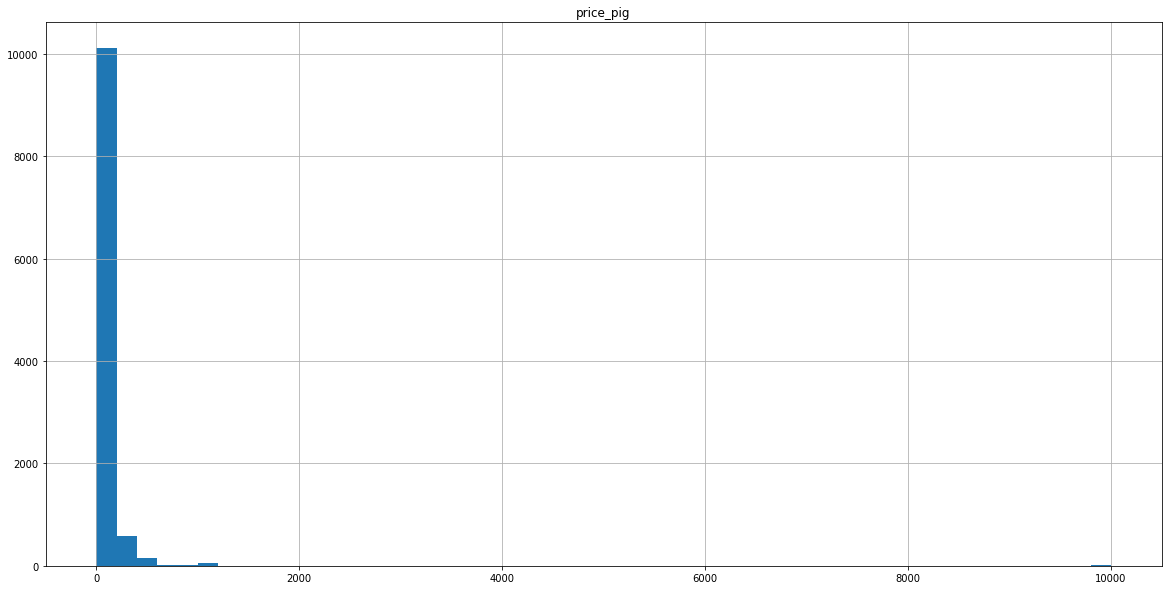

In [116]:
listings.hist(column = 'price_pig', bins = 50)

There are values of a dataset where the price per included guest is 0. The maximum price per included guest per night is £9,999. A really special feature of this dataset is that it includes the links to the Airbnb's pages. This means that, so long as the listing is still active, I can literally check to see if there is a reason that a value is extreme. I choose to use my own knowledge of hotel prices to create sensible upper and lower bounds for the data. Personally, I have found statistical methods (e.g. 3 standard deviations) often hide real features of the data. I use the price per included guest to make these judgements, because a property may appear to be an outlier just because it sleeps a large number of individuals. 

In [117]:
print(listings['price_pig'].min())
print(listings['price_pig'].max())

0.0
9999.0


Any Airbnb less than £8 per person a night would be a potential outlier, as this seems unreasonably cheap. There are 18 Airbnbs under £8 a night, and two of these are listed as costing nothing at all. I visually inspect these properties in the data for any feature that might explain this (e.g. they all have the same host, or are a special property type...). Airbnbs under £8 per person tend include many more people in the base rate than the mean for all Airbnbs in this dataset (mean ± standard deviation: 7.83 ± 4.93 vs 1.77 ± 1.50). It makes sense that Airbnbs that include more people would be cheaper per person because the 'bare minimum' costs to the host are split between all of the people. These are the same trends that I observed in the 2020-21 data (but not these datasets are not independent - many of the Airbnbs are present in both datasets!).

In [118]:
listings[listings.price_pig < 8][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people
655,7.000000,1,https://www.airbnb.com/rooms/3032366,14630118,6,84,3.0,Apartment,15.0
900,2.600000,3,https://www.airbnb.com/rooms/3769281,3713949,15,21,1.0,Apartment,0.0
1064,6.250000,1,https://www.airbnb.com/rooms/4453978,23112161,4,0,2.0,Apartment,20.0
3762,2.916667,1,https://www.airbnb.com/rooms/13937408,82866543,12,314,1.0,Apartment,10.0
5373,2.272727,1,https://www.airbnb.com/rooms/18609453,101731795,11,125,1.0,Townhouse,0.0
5851,5.000000,1,https://www.airbnb.com/rooms/19402102,136012860,4,0,2.0,Apartment,0.0
6343,4.062500,3,https://www.airbnb.com/rooms/19903475,140937670,16,92,1.0,Apartment,0.0
6948,0.000000,2,https://www.airbnb.com/rooms/20752585,2689840,1,0,1.0,Apartment,0.0
6998,7.500000,2,https://www.airbnb.com/rooms/20925062,105274239,6,0,3.0,Apartment,0.0
8953,6.125000,1,https://www.airbnb.com/rooms/25915418,194554364,16,131,4.0,Apartment,0.0


In fact, if I filter the results to only include Airbnbs with less than 5 guests (I choose this number because it is two deviations away from the mean for the whole sample), then I am only left with 6 results. Two of these are most likely errors as they are £0. I choose to exclude these 6 results.

In [119]:
listings[(listings.price_pig < 8) & (listings.guests_included < 5)][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people
1064,6.25,1,https://www.airbnb.com/rooms/4453978,23112161,4,0,2.0,Apartment,20.0
5851,5.00,1,https://www.airbnb.com/rooms/19402102,136012860,4,0,2.0,Apartment,0.0
6948,0.00,2,https://www.airbnb.com/rooms/20752585,2689840,1,0,1.0,Apartment,0.0
9735,5.00,2,https://www.airbnb.com/rooms/27163272,119509555,2,289,2.0,Apartment,20.0


In [120]:
listings = listings[(listings.price > 8) | (listings.guests_included >= 5)]

A luxury apartment might charge £1000 a night per person if it was also centrally located. Moreover, recall that price here is derived from the mean price, so Airbnbs that are exclusively available on the night of some special event (e.g. the Edinburgh Hogmanay festival) may seem inflated compared to others. Thirty-six Airbnbs exceed £1000 per night per person. Some hosts are very common in this subset. I could find no justification for these high values outside of error or an unusual quirk of availability (which unfortunately, I cannot correct for with the data I have), so I decided to exclude these data points.

In [121]:
listings[listings.price_pig > 1000][['price_pig', 'minimum_nights', 'listing_url', 'host_id', 'guests_included', 'availability_365', 'beds', 'property_type', 'extra_people']]

,price_pig,minimum_nights,listing_url,host_id,guests_included,availability_365,beds,property_type,extra_people
378,2600.00,2,https://www.airbnb.com/rooms/1367733,646220,2,0,1.0,Apartment,0.0
913,6747.00,1,https://www.airbnb.com/rooms/3797987,19504588,1,335,5.0,Apartment,18.0
994,1134.50,2,https://www.airbnb.com/rooms/4167650,20923270,2,15,3.0,Apartment,10.0
995,1133.00,2,https://www.airbnb.com/rooms/4167874,20923270,2,26,2.0,Apartment,10.0
2987,1500.00,1,https://www.airbnb.com/rooms/12385633,21782787,1,0,1.0,Apartment,0.0
3636,5000.00,1,https://www.airbnb.com/rooms/13745807,80447250,1,89,4.0,Apartment,0.0
3640,3000.00,1,https://www.airbnb.com/rooms/13756769,80447250,1,89,3.0,Apartment,0.0
3641,7000.00,1,https://www.airbnb.com/rooms/13756895,80447250,1,89,5.0,Apartment,0.0
3642,7000.00,1,https://www.airbnb.com/rooms/13756984,80447250,1,89,6.0,Apartment,0.0
4018,2354.00,1,https://www.airbnb.com/rooms/14225887,86457709,1,0,1.0,Apartment,0.0


In [122]:
listings = listings[(listings.price < 1000)]

The skew in price per included guest is still very extreme. However, I am unwilling to blindly remove any more data points at this stage without further justification for their removal. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D7D1D43588>]],
      dtype=object)

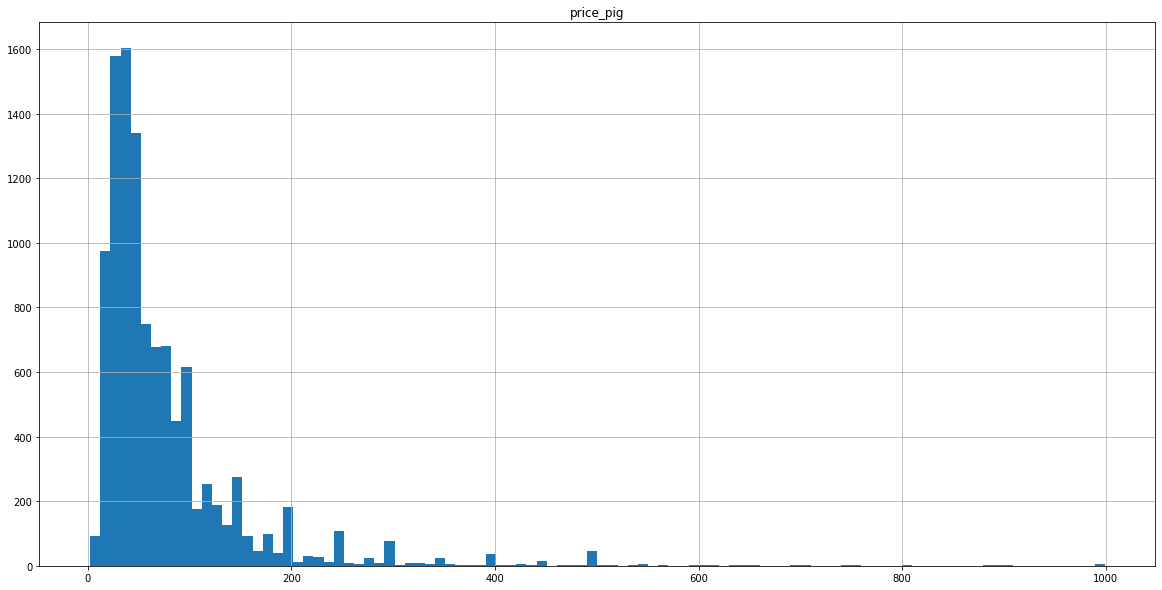

In [123]:
listings.hist(column = 'price_pig', bins = 100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D7CD94AB48>]],
      dtype=object)

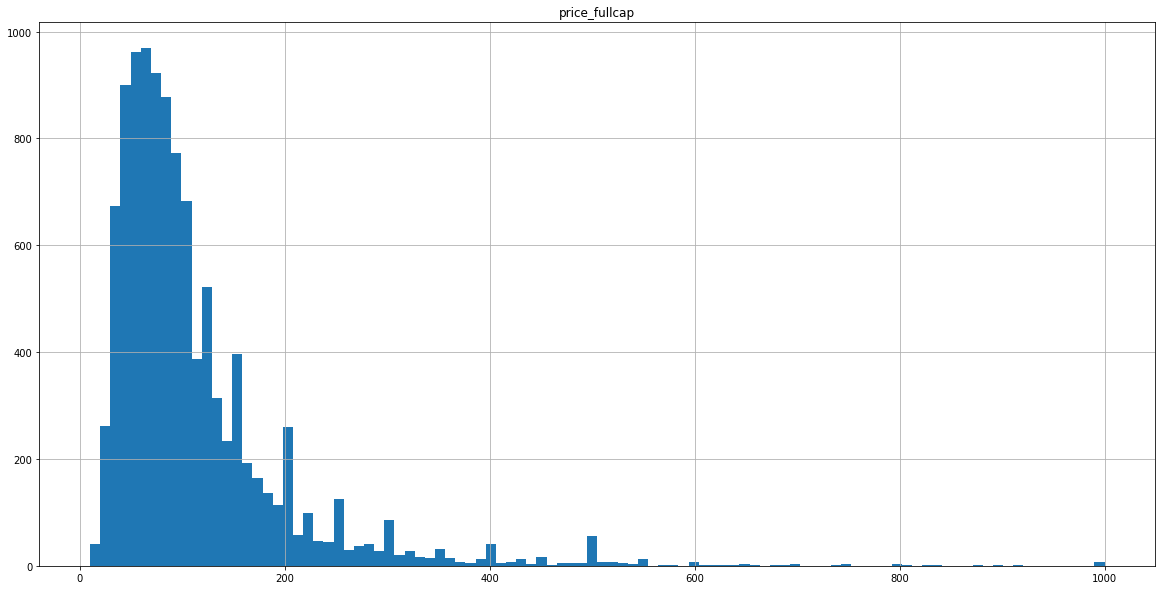

In [124]:
listings.hist(column = 'price_fullcap', bins = 100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002D7D1C3C388>]],
      dtype=object)

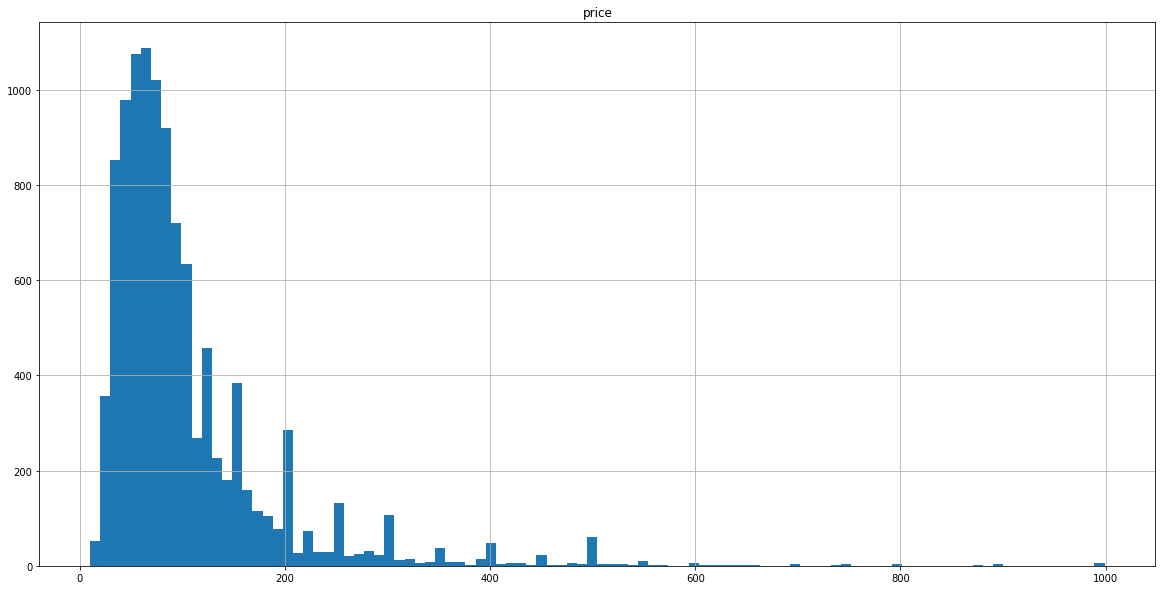

In [125]:
listings.hist(column = 'price', bins = 100)

## Ameneties

Below, I add a column that indicates whether an Airbnb has a real bed or not. Another column is the ratio of bathrooms to beds. I also pull a number of different amenities out of the ameneites column.

In [126]:
def bath_bed_ratio(row):
    if row['beds'] == 0:
        return 1
    else:
        return row['bathrooms']/row['beds']
    
listings['bath_bed_ratio'] = listings.apply(lambda row: bath_bed_ratio(row), axis = 1)

In [127]:
listings['real_bed'] = listings['bed_type'].apply(lambda x: 1 if (x == 'Real Bed') else 0)

def countAmenities(search_term, col_name):
    listings[col_name] = listings['amenities'].apply(lambda x: 1 if search_term in x else 0)
    return(listings)

amenitiesDict = {
    "pets": "Pets allowed",
    "first_aid": "First aid kit",
    "hair_dryer": "Hair dryer",
    "smoke_detector": "Smoke detector",
    "co_detector": "Carbon monoxide detector",
    "cooking": "Cooking basics",
    "stove": "Stove",
    "allday_checkin": "24-hour check-in",
    "extra_bedding": "Extra pillows and blankets",
    "hangers": "Hangers",
    "iron": "Iron",
    "no_stairs": "No stairs or steps to enter",
    "children": "Family/kid friendly",
    "aircon": "Air conditioning",
    "wifi": "Wifi",
    "essentials": "Essentials",
    "washer": "Washer",
    "garden": "Garden or backyard",
    "oven": "Oven",
    "gym": "Gym",
    "tv": "TV",
    "kitchen": "Kitchen",
    "cable": "Cable TV",
    "free_parking": "Free parking on premises",
    "breakfast": "Breakfast",
    "dishwasher": "Dishwasher",
    "crib": "Crib",
    "workspace": "Laptop friendly workspace",
    "lift": "Elevator",
    "wheelchair_access": "Wheelchair accessible",
    "balcony": "Patio or balcony",
    "bathtub": "Bathtub",
    "lugagge_dropoff": "Luggage dropoff allowed",
    "self_checkin": "Self check-in",
    "dryer": "Dryer",
    "waterfront": "Waterfront",
    "fireplace": "Indoor fireplace",
    "high_chair": "High chair",
    "hot_water": "Hot water",
    "microwave": "Microwave",
    "coffee": "Coffee maker"
}


for key in amenitiesDict:
    listings = countAmenities(amenitiesDict[key], key)

The columns `space`, `description`, `neighborhood_overview`, `summary` and `notes` offer large prose added by the owners of the Airbnb. At this moment in time, I choose to stick with the ameneties I have extracted, although these could be a source of further data.

I collapse together housing types and one hot encode them.

In [128]:
listings['house'] = listings['property_type'].apply(lambda x: 1 if x in ['House', 'Cottage', 'Townhouse', 'Bungalow', 'Tiny house'] else 0)
listings['apartment'] = listings['property_type'].apply(lambda x: 1 if x in ['Apartment', 'Serviced apartment', 'Condominium', 'Aparthotel'] else 0)
listings['hotel'] = listings['property_type'].apply(lambda x: 1 if x in ['Boutique hotel', 'Guest suite', 'Guesthouse', 'Hotel', 'Bed and breakfast'] else 0)
listings['hostel'] = listings['property_type'].apply(lambda x: 1 if x in ['Hostel'] else 0)
listings['other_property_type'] = listings['property_type'].apply(lambda x: 1 if x in ['Loft', 'Villa', 'Camper/RV', 'Other', 'Tent', 'Cabin', 'Campsite', 'Chalet', 'Hut', 'Casa particular (Cuba)', 'Farm stay', 'Barn', 'Boat'] else 0)

## Exploring Neighbourhoods and Geography

### One Hot Encoding

I one hot encode the neighbourhoods.

In [129]:
areas = pd.get_dummies(listings.neighbourhood, prefix='Area')
areas['id'] = listings['id']
listings = listings.merge(areas, on = 'id')
listings.head()

,id,listing_url,scrape_id,last_scraped,summary,space,description,neighborhood_overview,notes,transit,...,Area_Leith,Area_Marchmont,Area_Morningside,Area_New Town,Area_Newington,Area_Old Town,Area_Southside,Area_Stockbridge,Area_Tollcross,Area_West End
0,15420,https://www.airbnb.com/rooms/15420,20190625184115,2019-06-25,"Stunning, impeccably refurbished spacious grou...",This is a huge and luxurious apartment for 2 -...,"Stunning, impeccably refurbished spacious grou...","The neighbourhood is in the historic New Town,...",Please note that because of my interest in int...,It is easy to walk to many of the main tourist...,...,0,0,0,1,0,0,0,0,0,0
1,24288,https://www.airbnb.com/rooms/24288,20190625184115,2019-06-25,Boho rustic-chic former warehouse Loft located...,"Two bedroom, very central Loft apartment with ...",Boho rustic-chic former warehouse Loft located...,It's all in the mix: Culture-museums and galle...,The apartment is in the City centre so being a...,Walk to key central attractions or catch a bus...,...,0,0,0,0,0,0,1,0,0,0
2,44552,https://www.airbnb.com/rooms/44552,20190625184115,2019-06-25,Pleasant double room in 2 bedroom ground floor...,You will be staying in a pleasant double room ...,Pleasant double room in 2 bedroom ground floor...,NaN,NaN,There are frequent buses to the centre and oth...,...,1,0,0,0,0,0,0,0,0,0
3,47616,https://www.airbnb.com/rooms/47616,20190625184115,2019-06-25,Annemarie & I would like to welcome you to our...,The flat has two floors with bedrooms and bath...,Annemarie & I would like to welcome you to our...,We're at the quiet end of a residential street...,"As we are both working office-hours, arrivals ...",There are 30 bus routes within 5 minutes' walk...,...,0,0,0,0,0,0,1,0,0,0
4,48645,https://www.airbnb.com/rooms/48645,20190625184115,2019-06-25,Large comfortable private room in the heart of...,Your room is large with a very comfortable hig...,Large comfortable private room in the heart of...,The Canongate is an area rich in culture and h...,Edinburgh city center now has free unlimited w...,The apartment is 400 metres from the Airport B...,...,0,0,0,0,0,1,0,0,0,0


Then I examine the descriptive statistics of the pricing in each neighbourhood and visualise these results. Morningside, Leith, and Haymarket have the lowest median prices, uncorrected for number of guests included, whereas Old Town, West End, and New Town are the most expensive. Looking at price per included guest rather than overall price shifts the picture. Haymarket now joins Leith as having the lowest median price, whereas Newington and Marchmont join New Town as most expensive.  

Note how the standard deviations generally decrease when we account for number of included guests, because we are removing the variation that is introduced by the number of individuals a property can house. 

No statistical tests can be used to evaluate the differences in medians because not all properties are independent of each other: a property owner may own properties in multiple different areas. 

In [130]:
listings.groupby('neighbourhood')[['price']].describe().sort_values(('price', '50%'))

price                                                         
                count        mean         std   min   25%    50%    75%    max
neighbourhood                                                                 
Leith          3101.0   83.828120   65.999935  10.0  45.0   66.0   99.0  899.0
Morningside     342.0   82.903509   59.410886  12.0  40.0   67.0  100.0  450.0
Haymarket      1016.0   84.845472   67.893445  14.0  45.0   68.0  100.0  750.0
Newington       433.0   98.422633   84.896692  10.0  47.0   75.0  115.0  900.0
Tollcross       263.0   90.794677   61.557672  10.0  55.0   75.0  100.5  500.0
Cannonmills     477.0  103.540881   85.416632  20.0  57.0   79.0  120.0  999.0
Bruntsfield     287.0   99.435540   90.174860  10.0  47.5   80.0  120.0  900.0
Marchmont       720.0  110.840278   90.714247  10.0  50.0   80.0  140.0  570.0
Southside       479.0  107.308977   99.264115  10.0  50.0   80.0  120.0  800.0
Stockbridge     582.0  103.527491   77.564998  21.0  59.0   85.0  125.0  750.0
Old Town       1253.0  127.520351  109.569484  15.0  69.0   90.0  145.0  999.0
West End        771.0  115.692607   93.313771  19.0  60.0   90.0  140.0  999.0
New Town       1043.0  135.635666  108.587819  12.0  73.5  100.0  160.0  999.0

In [131]:
listings.groupby('neighbourhood')[['price_pig']].describe().sort_values(('price_pig', '50%'))

price_pig                                                       \
                  count       mean         std        min        25%     50%   
neighbourhood                                                                  
Haymarket        1016.0  61.832165   55.307914   2.916667  29.000000  45.000   
Leith            3101.0  64.895843   60.007824   2.600000  30.000000  48.500   
Bruntsfield       287.0  74.528397   85.164890   9.000000  32.000000  50.000   
Morningside       342.0  70.109771   58.307196   8.333333  34.250000  50.000   
Southside         479.0  79.953464   88.348274  10.000000  35.000000  50.000   
Tollcross         263.0  68.881754   63.204369   7.000000  33.333333  50.000   
Cannonmills       477.0  74.122065   75.805765   5.000000  32.500000  55.000   
Old Town         1253.0  93.435863  108.221074   6.250000  35.000000  55.000   
Stockbridge       582.0  82.365570   79.651660  11.250000  35.000000  55.000   
West End          771.0  79.441095   80.783487   9.375000  32.500000  55.000   
Marchmont         720.0  85.680655   82.133831   2.272727  35.000000  56.625   
Newington         433.0  81.790119   75.869227   5.000000  35.000000  60.000   
New Town         1043.0  94.185094  100.245868   5.555556  35.000000  65.000   

                              
                  75%    max  
neighbourhood                 
Haymarket       75.00  600.0  
Leith           80.00  899.0  
Bruntsfield     90.00  900.0  
Morningside     87.75  450.0  
Southside       90.00  800.0  
Tollcross       80.00  500.0  
Cannonmills     87.50  999.0  
Old Town       100.00  999.0  
Stockbridge    100.00  750.0  
West End        95.00  999.0  
Marchmont      105.00  570.0  
Newington      100.00  500.0  
New Town       110.00  999.0

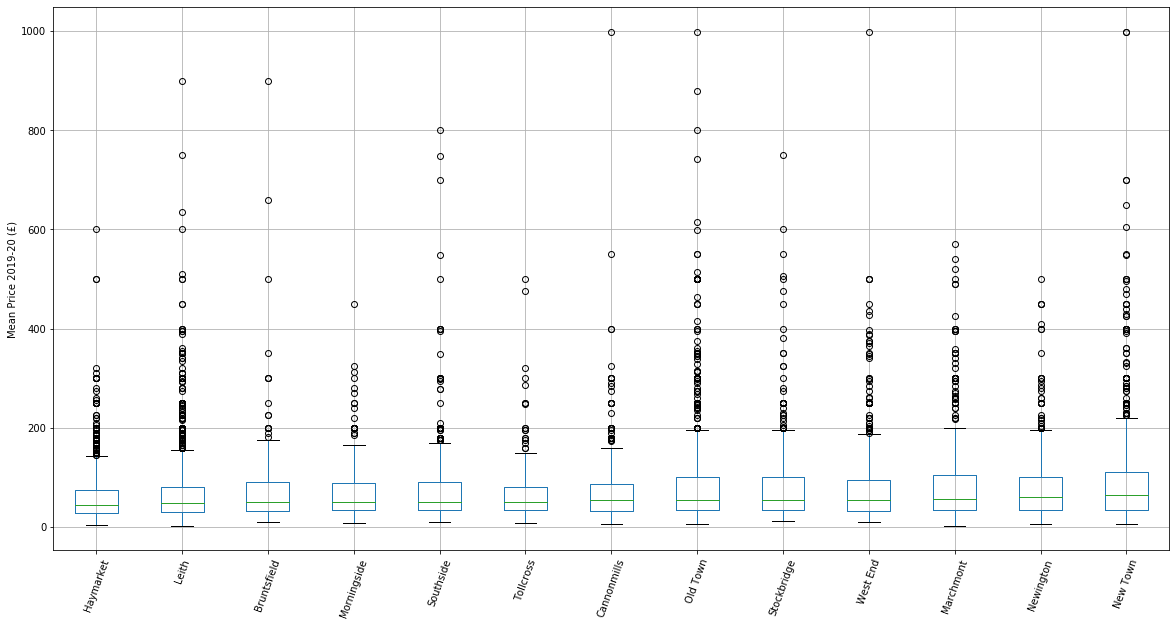

In [132]:
def boxplot_sorted(df, by, column):
  df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
  meds = df2.median().sort_values()
  return df2[meds.index].boxplot(rot=70)

plt.figure(figsize=(20,10))
fig = boxplot_sorted(listings, column = 'price_pig', by = 'neighbourhood')
fig.set_ylabel("Mean Price 2019-20 (£)")
plt.savefig('neighbourhood_pricepig_boxplot.png')

## Exploring Ratings and Host Characteristics

### Distributions and Outlier Detection

Review ratings are split into six variables which are scored out of 10: value for money, accuracy of description, cleanliness, communication, location and check-in. There is also an overall rating which is scored out of 100. All of these tend to cluster towards high scores.

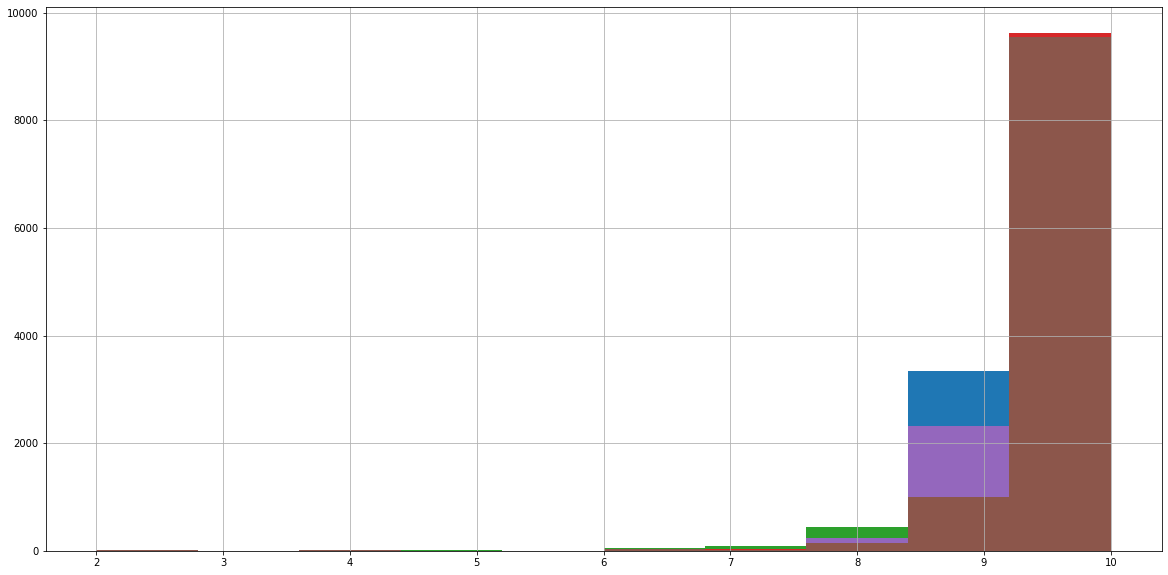

In [326]:
for rating in ['review_scores_value', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_checkin']:
    listings[rating].hist()

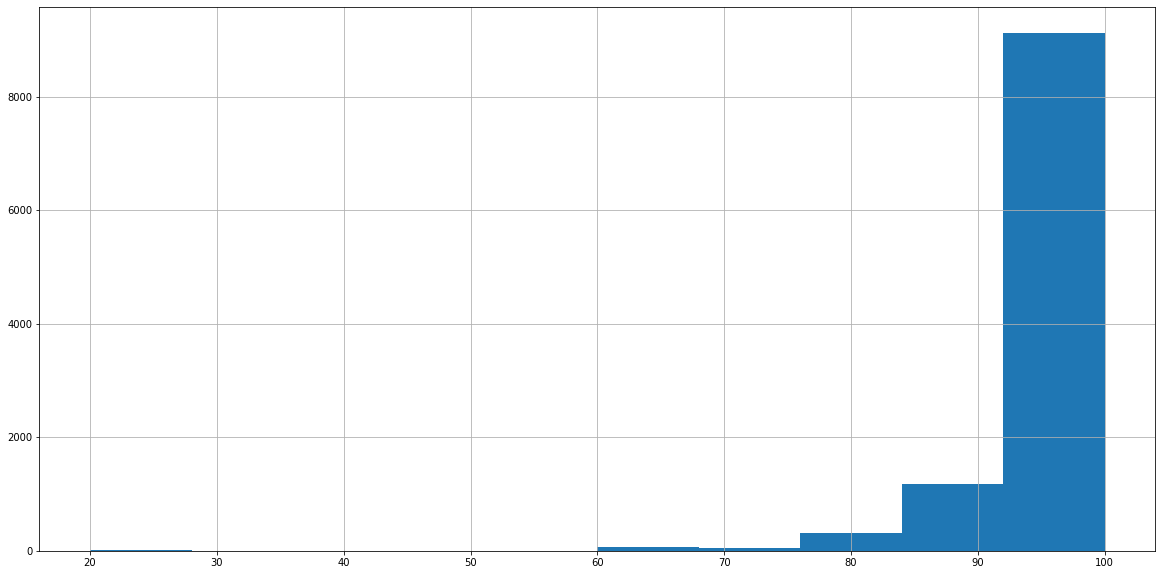

In [327]:
listings['review_scores_rating'].hist()

Host attributes that may correlate with pricing may be how long an individual has been a host for, their response time and rate, their location, how many Airbnbs they own, and their verification status. The same host can be represented multiple times in this dataset. Altogether, there are 7,544 unique hosts.

In [328]:
len(listings.host_id.unique())

7544

The number of Airbnbs they own is described as a simple integer in `host_listings_count`. The host's location is contained within both `host_neighbourhood` and `host_location`. The hosts neighbourhoods can be outside of Edinburgh, so are not particularly useful as there are many, many of them. I can use the `host_location` column to see whether or not a host has reported that they live in Edinburgh.

In [329]:
host_in_edin = [1 if area == "Edinburgh, Scotland, United Kingdom" else 0 for area in listings.host_location]
listings['host_in_edin'] = host_in_edin

Airbnb hosts are allowed to take bookings without having their identity verified with photo ID such as a driving licence or a passport. Such individuals have an f in the `host_identity_verified` column. Only around 37% of hosts in this dataset are verified.

Airbnb superhosts are hosts who meet a certain standard set by Airbnb: which includes high response rates, low cancellations, and high ratings. A key benefit of booking with a superhost is that they cannot cancel your booking. In this dataset, a host either is a superhost (t) or is not (f) as indicated by the `host_is_superhost` column. Around 32% of hosts in this dataset are superhosts. I recode these boolean columns into 1s and 0s. 

In [330]:
def get_percent_true(col, df):
    return sum(df[col])/len(df.index) * 100

print("% hosts that are verified: ", get_percent_true('host_identity_verified', listings))
print("% hosts that are superhosts: ", get_percent_true('host_is_superhost', listings))

% hosts that are verified:  36.85334819355438
% hosts that are superhosts:  31.884461781369


`host_response_time` is a categorical variable with four levels: within an hour, within a few hours, within a day, and a few days or more. `host_response_rate` is a percentage that describes the percentage of individuals who enquired that the host has responded to. Most hosts in the dataset have a high response rate.

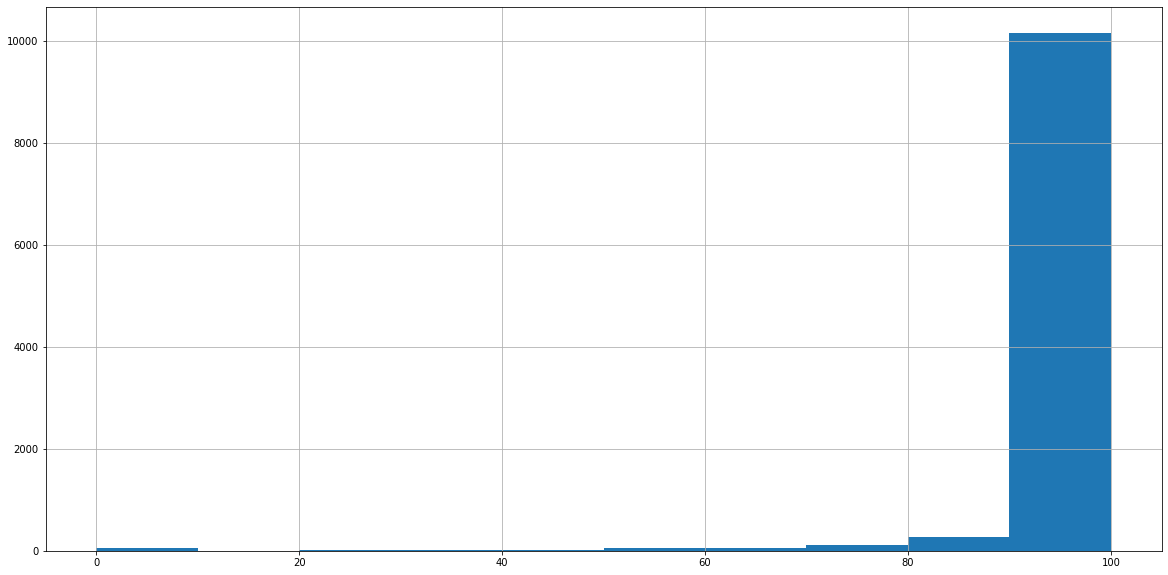

In [331]:
response_time = []

for item in listings.host_response_time:
    if item == "within an hour":
        response_time.append(3)
    elif item == "within a few hours":
        response_time.append(2)
    elif item == "within a day":
        response_time.append(1)
    elif item == "a few days or more":
        response_time.append(0)
    else:
        response_time.append(None)
        
listings['host_response_time'] = response_time

listings['host_response_rate'] = listings['host_response_rate'].str.replace('%', '')
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'])
listings.host_response_rate.hist()

### Correlations

There are some anticipated off-diagonal correlations: 
- Correlation between the area indicator variables and latatitude and longitude 
- Correlations between bed-bath ratio and average/full capacity price and variables indicating number of occupants (e.g. bedroom, bathroom, accomodates)
- Listings without descriptive elements (e.g. transit, description) are negatively correlated with amenities (probably because they didn't bother listing any)

In [332]:
listings_cor = listings.drop(['description', 'space', 'neighborhood_overview', 'notes', 'house_rules', 'transit'], axis = 1)

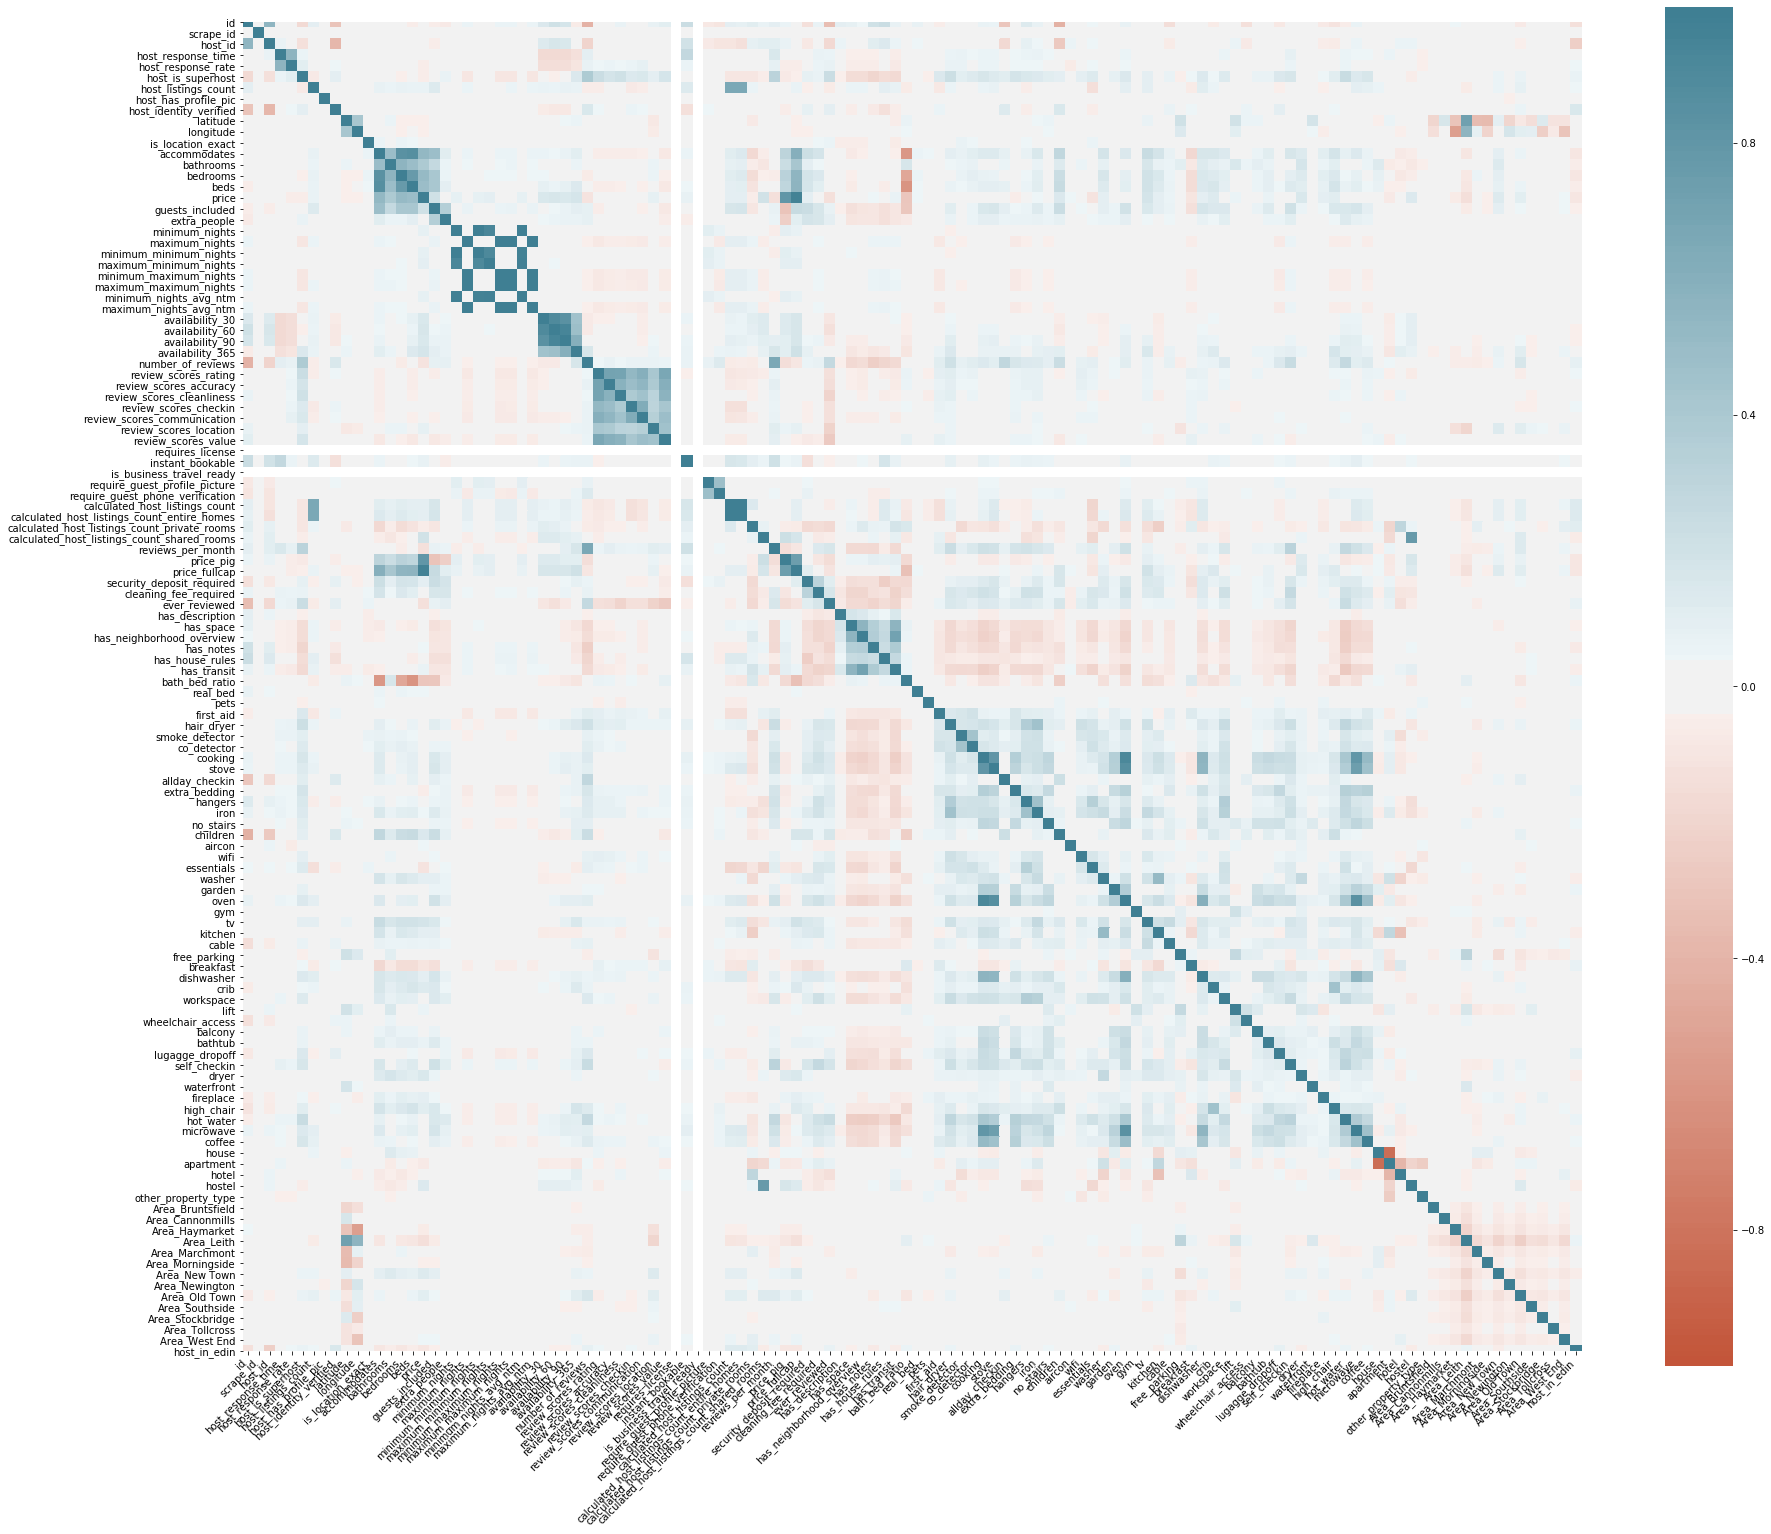

In [333]:
plt.rcParams["figure.figsize"] = (30,25)

corr = listings_cor.corr()
ax = sn.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sn.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

## Comparison of 2019-20 and 2020-21

Of the 10,767 properties in the cleaned 2019-21 dataset, 8,118 of these are also present in the cleaned 2020-21 dataset. This means that these datasets are not independent.

In [334]:
listings20 = pd.read_csv('../data20/listings2020_cleaned.csv')

listings20.head()

,id,listing_url,scrape_id,last_scraped,summary,space,description,neighborhood_overview,notes,transit,...,Area_Marchmont,Area_Morningside,Area_New Town,Area_Newington,Area_Old Town,Area_Southside,Area_Stockbridge,Area_Tollcross,Area_West End,host_in_edin
0,15420,https://www.airbnb.com/rooms/15420,20200623173438,2020-06-24,"Stunning, impeccably refurbished spacious grou...",This is a huge and luxurious apartment for 2 -...,"Stunning, impeccably refurbished spacious grou...","The neighbourhood is in the historic New Town,...",Please note that because of my interest in int...,It is easy to walk to many of the main tourist...,...,0,0,1,0,0,0,0,0,0,1
1,24288,https://www.airbnb.com/rooms/24288,20200623173438,2020-06-24,Boho rustic-chic former warehouse Loft located...,"Two bedroom, very central Loft apartment with ...",Boho rustic-chic former warehouse Loft located...,It's all in the mix: Culture-museums and galle...,The apartment is in the City centre so being a...,Walk to key central attractions or catch a bus...,...,0,0,0,1,0,0,0,0,0,1
2,44552,https://www.airbnb.com/rooms/44552,20200623173438,2020-06-24,Pleasant double room in 2 bedroom ground floor...,You will be staying in a pleasant double room ...,Pleasant double room in 2 bedroom ground floor...,NaN,NaN,There are frequent buses to the centre and oth...,...,0,0,0,0,0,0,0,0,0,1
3,47616,https://www.airbnb.com/rooms/47616,20200623173438,2020-06-24,Annemarie & I would like to welcome you to our...,The flat has two floors with bedrooms and bath...,Annemarie & I would like to welcome you to our...,We're at the quiet end of a residential street...,"As we are both working office-hours, arrivals ...",There are 30 bus routes within 5 minutes' walk...,...,0,0,0,0,0,1,0,0,0,1
4,48645,https://www.airbnb.com/rooms/48645,20200623173438,2020-06-24,Large comfortable private room in the heart of...,Your room is large with a very comfortable hig...,Large comfortable private room in the heart of...,The Canongate is an area rich in culture and h...,Edinburgh city center now has free unlimited w...,The apartment is 400 metres from the Airport B...,...,0,0,0,0,1,0,0,0,0,1


In [335]:
pd.merge(listings, listings20, on = 'id', how = 'inner').shape

(8118, 278)

In my exploration of the time series of pricing associated with these datasets, I observed a strong effect of inflation within years. This also appears to be the case between years.

In [336]:
print("Mean price in 2019/20: ", listings.price.mean(), " vs. mean price in 2020/21: ", listings20.price.mean())
print("Mean price per included guest in 2019/20: ", listings.price_pig.mean(), " vs. mean price per included guest in 2020/21: ", listings20.price_pig.mean())
print("Mean price at full capacity in 2019/20: ", listings.price_fullcap.mean(), " vs. mean price at full capacity in 2020/21: ", listings20.price_fullcap.mean())

Mean price in 2019/20:  102.24194297390174  vs. mean price in 2020/21:  106.99379065641632
Mean price per included guest in 2019/20:  76.41884873727658  vs. mean price per included guest in 2020/21:  78.33868506991286
Mean price at full capacity in 2019/20:  110.7152410142101  vs. mean price at full capacity in 2020/21:  116.5595308495959


## Prepare Datasets for Modelling

In [337]:
listings.to_csv('../data19/listings2019_cleaned.csv', index = False)